In [2]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

c:\Users\Erick\OneDrive\Documentos\projects\rs_streets\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root = tempfile.mkdtemp()
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220902T090559_R050_T40XDH_20220902T181115",
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220718T084609_R107_T40XEJ_20220718T175008",
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B02", "B03", "B04", "B08"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

100%|██████████| 197389773/197389773 [01:14<00:00, 2635652.90it/s]


100%|██████████| 192099728/192099728 [01:16<00:00, 2508866.58it/s]


100%|██████████| 186117847/186117847 [01:15<00:00, 2477153.13it/s]


100%|██████████| 185748811/185748811 [01:08<00:00, 2708809.36it/s]


100%|██████████| 198106313/198106313 [01:18<00:00, 2515171.66it/s]


100%|██████████| 195789388/195789388 [01:27<00:00, 2241690.46it/s]


100%|██████████| 193846206/193846206 [01:22<00:00, 2351176.69it/s]


100%|██████████| 200519427/200519427 [01:20<00:00, 2505424.93it/s]


In [4]:
class Sentinel2(RasterDataset):
    filename_glob = "T*_B02_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

In [ ]:
class Landsat9(RasterDataset):
    filename_glob = "L*_L2SP_\\d+_\"

In [5]:
dataset = Sentinel2(root)
print(dataset)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=399960.0, maxx=609780.0, miny=8190240.0, maxy=8400000.0, mint=1658151969.0, maxt=1662127559.999999)
    size: 2


In [6]:
class Sentinel2(RasterDataset):
    filename_glob = "T*_B02_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

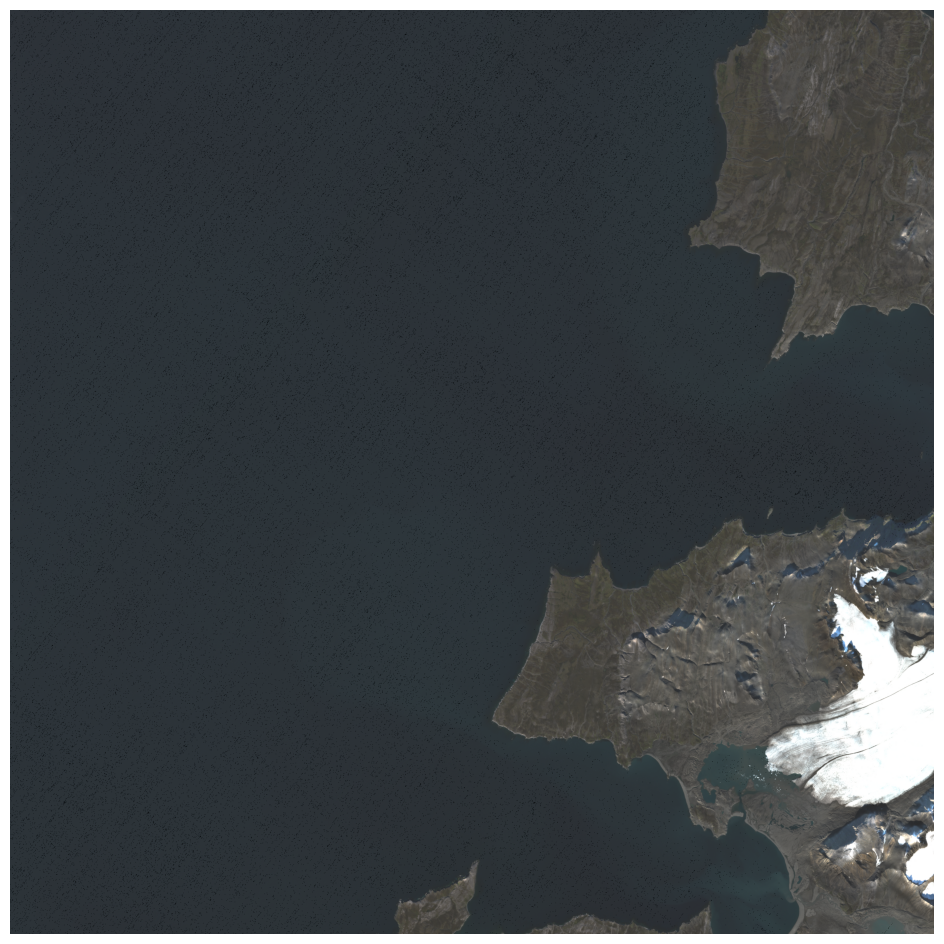

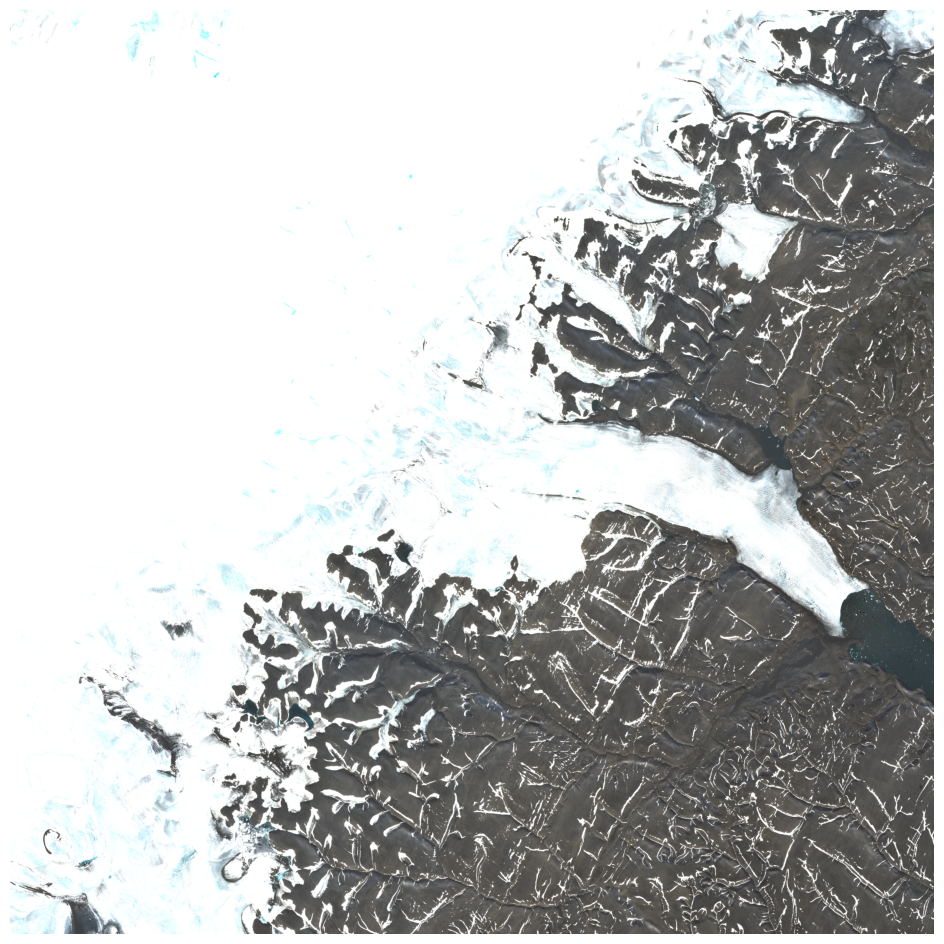

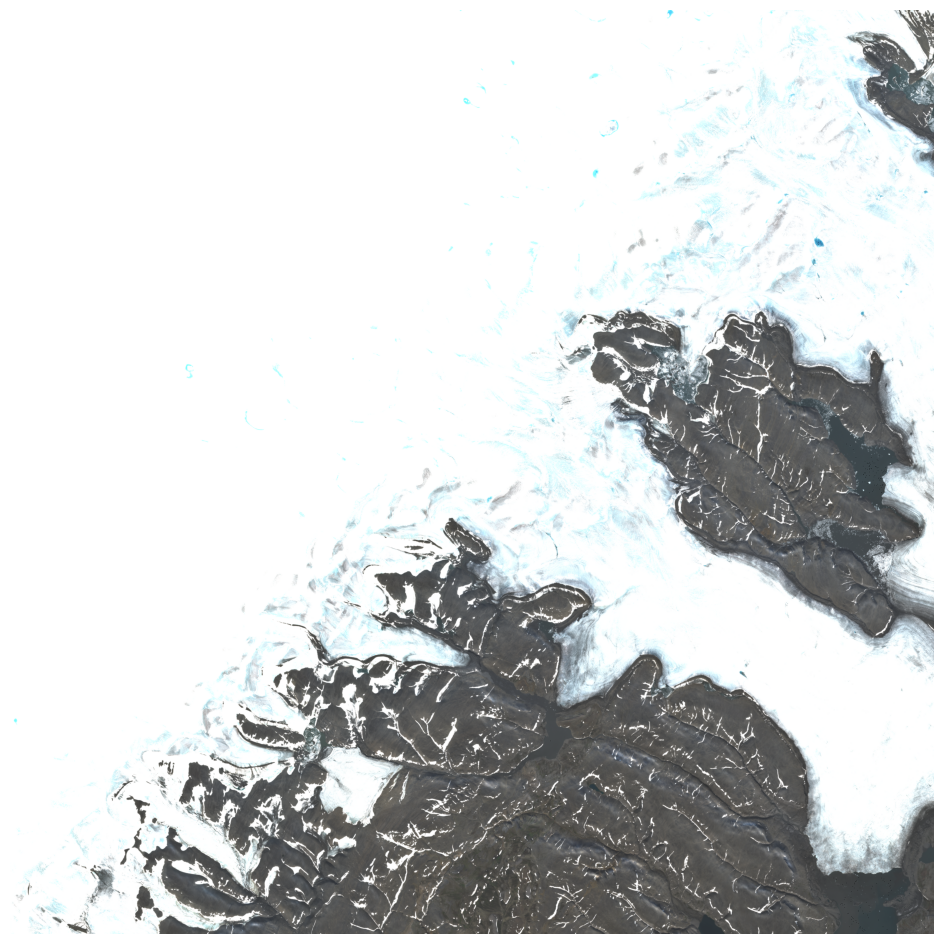

In [7]:
torch.manual_seed(1)

dataset = Sentinel2(root)
sampler = RandomGeoSampler(dataset, size=4096, length=3)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()